In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import balanced_accuracy_score

np.random.seed(0)

# Fairness
Load and shuffle the provided dataset.

In [2]:
df = pd.read_csv("MaternalHealthRiskDataSet.csv")
features = df.drop("RiskLevel", axis=1)
targets = df["RiskLevel"]
indices = np.random.permutation(features.index)
features = features.reindex(indices)
targets = targets.reindex(indices)
features.head()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate
921,23,120,90,7.5,98.0,70
75,23,130,70,6.9,98.0,70
608,35,100,70,7.5,98.0,66
630,22,100,65,12.0,98.0,80
380,13,90,65,7.8,101.0,80


Let us split the dataset into two age groups and visualize the distribution of the feature `Age` in each group:

Counts: 252 "old", 762 "young".
Class distribution: {'low risk': 406, 'mid risk': 336, 'high risk': 272}


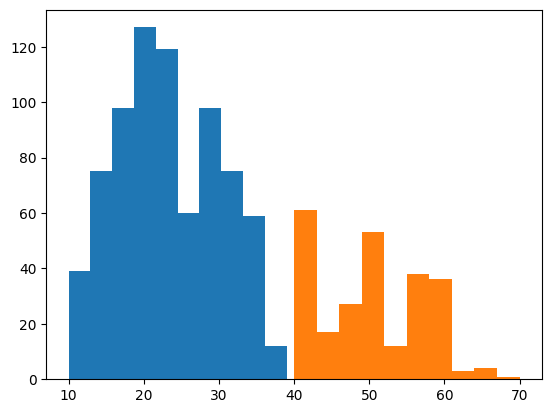

In [3]:
age_limit = 40
older_indices = (features["Age"] >= age_limit)
n_old = len(features[older_indices])
n_young = len(features[~older_indices])
print(f"Counts: {n_old} \"old\", {n_young} \"young\".")
print(f"Class distribution: {dict(targets.value_counts())}")

X_old = features[older_indices]
y_old = targets[older_indices]
X_young = features[~older_indices]
y_young = targets[~older_indices]

plt.hist(X_young["Age"], label="younger group")
plt.hist(X_old["Age"], label="elder group")
plt.show()

Split into training and test data.

In [4]:
X_old_train, X_old_test, y_old_train, y_old_test = train_test_split(X_old, y_old, test_size=0.2, random_state=0)
X_young_train, X_young_test, y_young_train, y_young_test = train_test_split(X_young, y_young, test_size=0.2, random_state=0)

Train and evaluate model using all the training data from the young group but only a fraction of the training data from the old group. We train a gradient boosting classifier. For simplicity, we do not perform any cross validation.

In [5]:
def train_and_evaluate_classifier(
    r, 
    X_old_train, 
    X_young_train, 
    y_old_train, 
    y_young_train, 
    X_old_test, 
    y_old_test, 
    X_young_test,
    y_young_test
):
    # Assemble training data
    k_old = int(len(X_old_train) * r) # Use fraction r of samples from the old group
    X_train = pd.concat([X_old_train[:k_old], X_young_train])
    y_train = pd.concat([y_old_train[:k_old], y_young_train])
    
    # TODO: Fit classifier on training data
    clf = GradientBoostingClassifier()
    clf.fit(X_train, y_train)
    
    # TODO: Evaluate model on the test data for each group separately
    y_old_pred = clf.predict(X_old_test)
    y_young_pred = clf.predict(X_young_test)

    acc_old = balanced_accuracy_score(y_old_test, y_old_pred)
    acc_young = balanced_accuracy_score(y_young_test, y_young_pred)
    return acc_old, acc_young


Old group accuracy: 0.7391867391867392
Young group accuracy: 0.7797550776583034


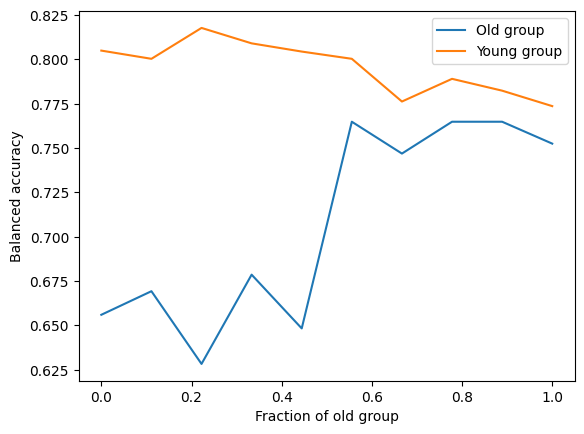

In [6]:
# TODO: Train and evaluate the model for different values of r
acc_old, acc_young = train_and_evaluate_classifier(0.5, X_old_train, X_young_train, y_old_train, y_young_train, X_old_test, y_old_test, X_young_test, y_young_test)
print(f"Old group accuracy: {acc_old}")
print(f"Young group accuracy: {acc_young}")
# TODO: Plot the accuracy for each group as a function of r

r = np.linspace(0, 1, 10)

acc_old = []
acc_young = []
for i in r:
    acc_o, acc_y = train_and_evaluate_classifier(i, X_old_train, X_young_train, y_old_train, y_young_train, X_old_test, y_old_test, X_young_test, y_young_test)
    acc_old.append(acc_o)
    acc_young.append(acc_y)

plt.plot(r, acc_old, label="Old group")
plt.plot(r, acc_young, label="Young group")
plt.xlabel("Fraction of old group")
plt.ylabel("Balanced accuracy")
plt.legend()
plt.show()


# Naive Bayes classifiers

In [7]:
from sklearn.naive_bayes import CategoricalNB
from sklearn.preprocessing import OrdinalEncoder

1. $2^{d+1}$
2. Under the naive Bayes assumption, the number of probabilities needed is $O(d)$, where $f(d)=d$

### Categorical naive Bayes Classifier

In [8]:
df = pd.read_csv("Tennis.csv")
features = df.drop("PlayTennis", axis=1)
targets = df["PlayTennis"]
indices = np.random.permutation(features.index)
features = features.reindex(indices)
targets = targets.reindex(indices)
features.head()

,Weather,Temperature,Humidity,Wind
8,Rainy,Cool,Normal,No
6,Overcast,Cool,Normal,Yes
2,Overcast,Hot,High,No
1,Rainy,Hot,High,Yes
3,Sunny,Mild,High,No


In [9]:
# 3
print(f"targets classes: {targets.unique()}")

for col in features.columns:
    print(f"{col}: {features[col].unique()}")

targets classes: ['Yes' 'No']
Weather: ['Rainy' 'Overcast' 'Sunny']
Temperature: ['Cool' 'Hot' 'Mild']
Humidity: ['Normal' 'High']
Wind: ['No' 'Yes']


4. In this case, the Naive Bayes assumption may not be entirely realistic because features like Weather, Humidity, and Wind could be correlated in real-world weather patterns (e.g., Rainy weather might be more likely to have high humidity). It could still yield useful results.
5. yeah
6. given the observed data, it is 50/50

In [10]:
# Define conditions and calculate probability for each given PlayTennis = "No"
conditions = {
    "Weather": "Overcast",
    "Temperature": "Cool",
    "Humidity": "High",
    "Wind": "Yes"
}

playtennis_yes = features[targets == "Yes"]
playtennis_no = features[targets == "No"]

prob_yes = len(playtennis_yes) / len(features)
prob_no = len(playtennis_no) / len(features)


def calculate_conditional_probs(playtennis_df):
    probs = []
    for feature, value in playtennis_df.items():
        count  = len(playtennis_df[playtennis_df[feature] == value])
        if count == 0:
            probs.append(0)
            continue    
        probs.append(count / len(playtennis_df))
    return np.prod(probs)

probs_yes_num = calculate_conditional_probs(playtennis_yes) * prob_yes
probs_no_num = calculate_conditional_probs(playtennis_no) * prob_no

probability_no = probs_no_num / (probs_no_num + probs_yes_num)
probability_yes = probs_yes_num / (probs_no_num + probs_yes_num)
print(f"Probabilities for PlayTennis = Yes: {probability_yes}")
print(f"Probabilities for PlayTennis = No: {probability_no}")

Probabilities for PlayTennis = Yes: 0.6428571428571429
Probabilities for PlayTennis = No: 0.35714285714285715


In [11]:
conditions = {
    "Weather": "Overcast",
    "Temperature": "Cool",
    "Humidity": "High",
    "Wind": "Yes"
}

# Smoothing parameter (Laplace smoothing)
alpha = 1

# Calculate prior probabilities
playtennis_yes = features[targets == "Yes"]
playtennis_no = features[targets == "No"]

prob_yes_prior = len(playtennis_yes) / len(features)
prob_no_prior = len(playtennis_no) / len(features)

# Function to calculate conditional probabilities
def calculate_conditional_probs(playtennis_df):
    probs = []
    for feature, value in conditions.items():
        count = len(playtennis_df[playtennis_df[feature] == value])
        num_unique_values = len(features[feature].unique())
        prob = (count + alpha) / (len(playtennis_df) + alpha * num_unique_values)
        probs.append(prob)
    return np.prod(probs)

# Calculate the numerators of the posterior probabilities
prob_yes_numerator = calculate_conditional_probs(playtennis_yes) * prob_yes_prior
prob_no_numerator = calculate_conditional_probs(playtennis_no) * prob_no_prior

# Normalize to get the posterior probabilities
total_prob = prob_yes_numerator + prob_no_numerator
prob_yes_posterior = prob_yes_numerator / total_prob
prob_no_posterior = prob_no_numerator / total_prob

# Output the probabilities
print(f"P(Yes|conditions): {prob_yes_posterior:.2f}")
print(f"P(No|conditions): {prob_no_posterior:.2f}")


P(Yes|conditions): 0.67
P(No|conditions): 0.33


In [12]:

conditions = {
    "Weather": "Overcast",
    "Temperature": "Cool",
    "Humidity": "High",
    "Wind": "Yes"
}
conditions_df = pd.DataFrame([conditions])

# Encode categorical features using OrdinalEncoder
encoder = OrdinalEncoder()
encoded_features = encoder.fit_transform(features)
encoded_conditions = encoder.transform(conditions_df)

# Encode targets as integers
encoded_targets = targets.apply(lambda x: 1 if x == "Yes" else 0)

# Fit the Naive Bayes classifier
clf = CategoricalNB(alpha=1)
clf.fit(encoded_features, encoded_targets)

# Predict probabilities for the given conditions
probabilities = clf.predict_proba(encoded_conditions)

# Output the probabilities
prob_no = probabilities[0][0]
prob_yes = probabilities[0][1]
print(f"P(Yes|conditions): {prob_yes:.2f}")
print(f"P(No|conditions): {prob_no:.2f}")


P(Yes|conditions): 0.67
P(No|conditions): 0.33
